In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

https://www.kaggle.com/manabendrarout/custom-stacking-of-classifiers-gpu-tps-sep2021

manabendrarout

# Parameters

In [2]:
target = 'claim'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-sep-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_solution.csv")

# Preprocessing

In [5]:
features = [col for col in train.columns if 'f' in col]

In [6]:
train['n_missing'] = train[features].isna().sum(axis=1)
test['n_missing'] = test[features].isna().sum(axis=1)

train['std'] = train[features].std(axis=1)
test['std'] = test[features].std(axis=1)

features += ['n_missing', 'std']

In [7]:
ss = StandardScaler()


In [8]:
test[features]

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f111,f112,f113,f114,f115,f116,f117,f118,n_missing,std
0,0.165850,0.487050,1295.00,0.023100,0.31900,0.901880,573.29,3743.7,2.705700e+12,6221.000000,...,2.0655,0.430880,-10.7410,81606.00,1.1940,1.980400e+14,2017.10,0.46357,1,5.589410e+15
1,0.129650,0.373480,1763.00,0.728840,0.33247,-1.263100,875.55,554370.0,5.955700e+14,934.430000,...,1.5736,-1.071200,11.8320,90114.00,1.1507,4.388000e+16,6638.90,0.28125,0,4.080971e+15
2,0.120190,0.445210,736.26,0.046150,0.29605,0.316650,2659.50,317140.0,3.977800e+14,131.810000,...,2.1364,-1.931200,-3.2804,37739.00,1.1548,1.718100e+14,5844.00,0.13797,1,4.054317e+13
3,0.054008,0.395960,996.14,0.859340,0.36678,-0.170600,386.56,325680.0,-3.432200e+13,-26.473000,...,1.5199,-0.011633,1.3840,26849.00,1.1490,2.138800e+17,6173.30,0.32910,0,1.999852e+16
4,0.079947,-0.006919,10574.00,0.348450,0.45008,-1.842000,3027.00,428150.0,9.291500e+11,5999.400000,...,3.7387,0.757080,-4.9405,50336.00,1.2488,2.151300e+17,2250.10,0.33796,0,1.980389e+16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493469,-0.009112,0.308190,637.64,0.778200,0.41415,-1.068500,651.22,985000.0,6.079700e+15,508.820000,...,2.3325,0.112260,-5.9238,NaN,1.1559,8.163900e+16,857.09,1.56330,2,1.123239e+16
493470,0.088922,0.482650,6924.10,0.025963,0.35540,-0.870200,2514.20,18004.0,6.073500e+14,-0.008665,...,1.7005,97.813000,4.3793,-2432.00,1.0707,4.691800e+16,7497.10,0.67075,0,4.335915e+15
493471,0.140620,0.484750,1797.10,0.147020,0.28803,-1.407100,434.03,333050.0,2.351000e+15,33492.000000,...,1.6827,NaN,8.0633,2471.40,1.1725,7.900900e+16,2904.60,0.18005,5,7.433839e+15
493472,0.168000,0.351760,454.79,0.164580,0.16983,0.323850,2331.20,223980.0,-2.795300e+12,93.561000,...,1.3531,155.210000,13.9630,-11.44,1.1946,-1.770600e+14,6763.10,0.33223,0,1.172729e+16


In [9]:
train[target]

0         1
1         0
2         1
3         1
4         1
         ..
957914    0
957915    1
957916    0
957917    1
957918    0
Name: claim, Length: 957919, dtype: int64

# LGB

In [10]:
lgb_params = {
    'objective': 'binary',
     'n_estimators':N_ESTIMATORS,
     #'importance_type': 'gain',
     'metric':'auc',
     #'boosting_type': 'gbdt',
     'n_jobs' : -1,
        
   
    
    'learning_rate': 5e-3,
    'subsample': 0.6,
    'subsample_freq': 1,
    'colsample_bytree': 0.4,
    'reg_alpha': 10.0,
    'reg_lambda': 1e-1,
    'min_child_weight': 256,
    'min_child_samples': 20,
   
}

In [11]:
lgb_oof = np.zeros(train.shape[0])
lgb_pred = np.zeros(test.shape[0])
lgb_importances = pd.DataFrame()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED+9]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")
    if fold >4:

        X_train = train[features].iloc[trn_idx]
        y_train = train[target].iloc[trn_idx]
        X_valid = train[features].iloc[val_idx]
        y_valid = train[target].iloc[val_idx]
        X_test = test[features]

        X_train[features] = X_train[features].fillna(X_train[features].median())
        X_valid[features] = X_valid[features].fillna(X_valid[features].median())
        X_test[features] = X_test[features].fillna(X_test[features].median())

        X_train[features] = ss.fit_transform(X_train[features])
        X_valid[features] = ss.transform(X_valid[features])
        X_test[features] = ss.transform(X_test[features])

        start = time.time()
        for inseed in seed_list:
            lgb_params['random_state'] = inseed

            pre_model = lgb.LGBMClassifier(**lgb_params)
            pre_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='auc',
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
            )

            lgb_params2 = lgb_params.copy()
            lgb_params2['reg_lambda'] *= 0.9
            lgb_params2['reg_alpha'] *= 0.9
            lgb_params2['learning_rate'] *= 0.1
            model = lgb.LGBMClassifier(**lgb_params2)
            model.fit(
                    X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='auc',
                    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                    verbose=VERBOSE,
                    init_model=pre_model
            )    

            with open(f"lgb_model{fold}_seed{inseed}.pkl", 'wb') as f:
                pickle.dump(model, f)

            fi_tmp = pd.DataFrame()
            fi_tmp['feature'] = model.feature_name_
            fi_tmp['importance'] = model.feature_importances_
            fi_tmp['fold'] = fold
            fi_tmp['seed'] = inseed
            lgb_importances = lgb_importances.append(fi_tmp)

            lgb_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
            lgb_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)


        elapsed = time.time() - start
        auc = roc_auc_score(y_valid, lgb_oof[val_idx])
        print(f"fold {fold} - lgb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")            

lgb_pred /= N_SPLITS
print(f"oof lgb_auc = {roc_auc_score(train[target], lgb_oof)}")

np.save("lgb_oof.npy", lgb_oof)
np.save("lgb_pred.npy", lgb_pred)

===== fold 0 =====
===== fold 1 =====
===== fold 2 =====
===== fold 3 =====
===== fold 4 =====
===== fold 5 =====
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's auc: 0.809792
[2000]	valid_0's auc: 0.811633
[3000]	valid_0's auc: 0.812588
[4000]	valid_0's auc: 0.813229
[5000]	valid_0's auc: 0.813721
[6000]	valid_0's auc: 0.814021
[7000]	valid_0's auc: 0.814241
[8000]	valid_0's auc: 0.814413
[9000]	valid_0's auc: 0.814564
[10000]	valid_0's auc: 0.814695
[11000]	valid_0's auc: 0.814832
[12000]	valid_0's auc: 0.814919
[13000]	valid_0's auc: 0.815003
[14000]	valid_0's auc: 0.815028
[15000]	valid_0's auc: 0.815077
Early stopping, best iteration is:
[14945]	valid_0's auc: 0.815083
Training until validation scores don't improve for 300 rounds
[15000]	valid_0's auc: 0.815084
[16000]	valid_0's auc: 0.815089
[17000]	valid_0's auc: 0.815094
[18000]	valid_0's auc: 0.815104
[19000]	valid_0's auc: 0.815108
Early stopping, best iteration is:
[18831]	valid_0's auc: 0.8151

# OOF predictions

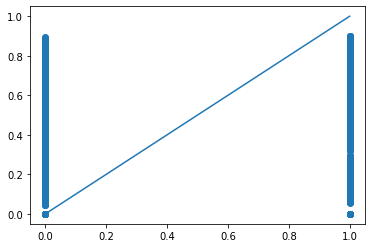

In [12]:
plt.plot(train[target], train[target])
plt.scatter(train[target], lgb_oof)

# Features importances

Text(0.5, 1.0, 'LightGBM feature importances')

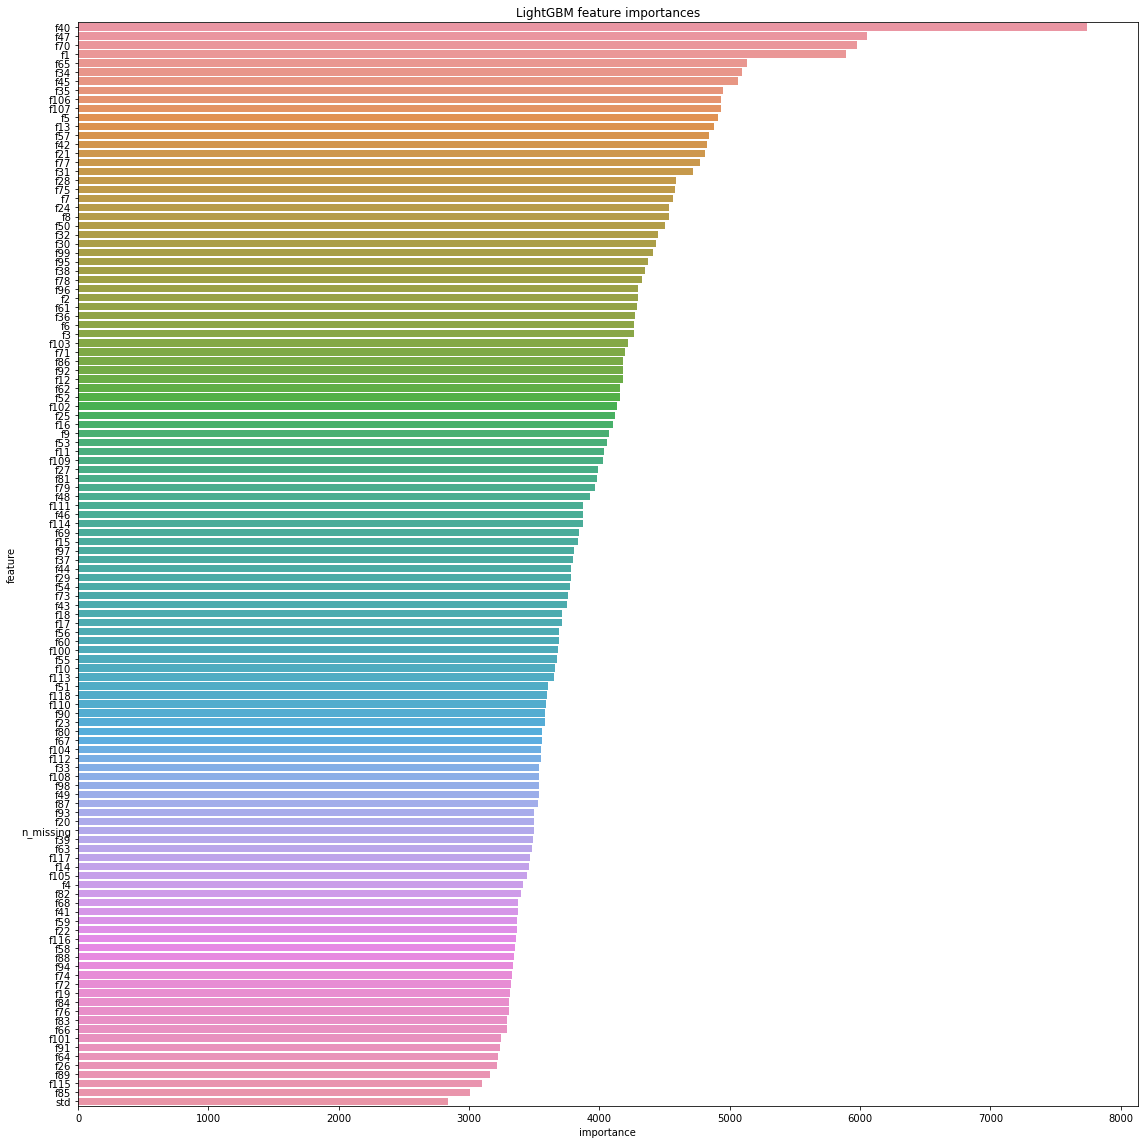

In [13]:
order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=lgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LightGBM feature importances")

# Submission

In [14]:
submission[target] = lgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,claim
0,957919,0.279705
1,957920,0.060162
2,957921,0.311747
3,957922,0.063955
4,957923,0.076830
...,...,...
493469,1451388,0.415131
493470,1451389,0.055897
493471,1451390,0.376669
493472,1451391,0.067769


# Log

mean ver3 fold 0-4 ver4 fold 5-9
0.8165301880013356

median ver6 fold 0-4 ver7 fold 5-9 
0.8165581192557307
ver8 aggregate seed 2017
2018 ver10 fold 0-4 ver11 fold 5-9 
2019 ver12 fold 0-4 ver13 fold 5-9
2020 ver14 fold 0-4 ver15 fold 5-9
2021 ver16 fold 0-4 ver17 fold 5-9
2022 ver18 fold 0-4 ver19 fold 5-9
2023 ver20 fold 0-4 ver21 fold 5-9
2024 ver22 fold 0-4 ver23 fold 5-9
2025 ver24 fold 0-4 ver25 fold 5-9
2026 ver26 fold 0-4 ver27 fold 5-9